#Low Rank Matrix Approximation


## Overview

We will be implementing and applying low-rank approximation of matrices, which is useful for finding hidden relationships that might not be apparent from high-dimensional data.

<ins>Format of this notebook:<ins>
1. Implement Low Rank Matrix Approximation (LORMA)
2. Perform movie recommendation using LORMA
    * For this part, I will use the `ratings.csv` and `movies.csv` files

Implement average squared loss function (8 pts)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Given M, M_approx, O, return the average squared loss over the observed entries.
#
# parameters
# M:        m x n 2-D numpy array
#           containing the observed entries (with arbitrary values in the unobserved entries)
#
# M_approx: m x n 2-D numpy array
#           representing the low-dimensional approximation
#
# O:        m x n 2-D numpy array
#           containing 0 if the entry is unobserved and 1 if the entry is observed in M.
#           O tells you which entries in M were observed (corresponds to \Omega in the equations above)
#
# output
# loss:     average of squared loss over observed entries

def loss(M, M_approx, O):
    ### ACT1: add your code here
    M_copy = np.multiply(M,O)
    M_approx_copy = np.multiply(M_approx,O)
    omega_size = np.count_nonzero(O)
    residual_matrix = M_copy - M_approx_copy
    residual_matrix_sq = np.square(residual_matrix)
    summation = np.sum(residual_matrix_sq)
    return summation/omega_size

# Testing
def check_loss():
    M = np.array([[2, 4, 1], [1, -3, 1]])
    M_approx = np.zeros((2, 3))
    O = np.array([[1, 0, 0], [0, 1, 1]])
    answer = 14 / 3
    output = loss(M, M_approx, O)
    assert(np.isclose(answer, output))
    print("Function {} is working fine!".format('loss()'))

check_loss()

Function loss() is working fine!


Return the normalized version of M (8 pts)


In [ ]:
# Given M, O, return the normalized version of M
#
# parameters
# M:        m x n 2-D numpy array
#           containing the observed entries (with arbitrary values in the unobserved entries)
#
# O:        m x n 2-D numpy array
#           containing 0 if the entry is unobserved and 1 if the entry is observed in M.
#           O tells you which entries in M were observed (corresponds to \Omega in the equations above)
#
# output
# M:        m x n 2-D numpy array
#           normalized copy of the input matrix M

def get_normalized_matrix(M, O):

    M_copy = np.multiply(M,O)
    summation = np.sum(M_copy)
    size = np.count_nonzero(M_copy);
    mean = summation / size
    mean_matrix = O * mean
    residual = M_copy - mean_matrix
    var = np.square(residual)
    var = np.sum(var)/size
    stddev = np.sqrt(var)
    M_normalized = M - mean
    M_normalized = M_normalized/stddev
    return M_normalized




# Testing
def check_normalization():
    M = np.random.rand(10, 3)
    O = (np.random.rand(10, 3) > 0.5) + 0
    Mn = get_normalized_matrix(M, O)
    assert(abs(np.sum(M * O)) > 1e-6)
    assert(abs(np.sum(Mn * O)) < 1e-6)
    assert(abs(np.sum(Mn**2 * O) / np.sum(O) - 1) < 1e-6)
    print("Function {} is working fine!".format('get_normalized_matrix()'))

check_normalization()

Function get_normalized_matrix() is working fine!


Implement LORMA's prediction (3 pts)

In [ ]:
# Given A, B, the low-rank matrices, calculate and return M_approx (M hat above)
#
# parameters
# A:        m x k 2-D numpy array
# B:        k x n 2-D numpy array
#
# output
# M_approx: m x n 2-D numpy array
def lorma(A, B):
    return A @ B

#### ACT4: Implement LORMA gradient (10 pts)

In [ ]:
# Given M, O, A, B return dL/dA, dL/dB.
#
# parameters
# M:        m x n 2-D numpy array
#           containing the observed entries (with arbitrary values in the unobserved entries)
#
# O:        m x n 2-D numpy array
#           containing 0 if the entry is unobserved and 1 if the entry is observed in M.
#           O tells you which entries in M were observed (corresponds to \Omega in the equations above)
#
# A:        m x k 2-D numpy array
# B:        k x n 2-D numpy array
#
# output
# dL/dA:    m x k 2-D numpy array
# dL/dB:    k x n 2-D numpy array

def lorma_grad(M, O, A, B):

    M_approx = lorma(A,B)
    M_approx_copy = np.multiply(M_approx,O)
    M_copy = np.multiply(M,O)
    size = np.count_nonzero(M_approx_copy);
    dM = 2*(M_approx_copy-M_copy)/size
    dA = dM @ np.transpose(B)
    dB = np.transpose(A) @ dM


    return dA, dB

#### ACT5: Implement LORMA initialization (8 pts)

In [ ]:
# Given m, n, k, initialize and normalize A, B as per the guideline above
#
# parameters
# m, n, k:  shapes for A, B
#
# output
# A:        m x k 2-D numpy array
# B:        k x n 2-D numpy array
#

def lorma_init(m, n, k):
    A = np.random.standard_normal((m,k))
    B = np.random.standard_normal((k,n))
    A = np.multiply(A,1/np.linalg.norm(A,axis=1,keepdims=True))
    B = np.multiply(1/ np.linalg.norm(B,axis=0), B)
    return A, B

# Testing
def check_lorma_init():
    A, B = lorma_init(10, 7, 3)
    assert(np.linalg.norm(np.diag(A @ A.T) - np.ones(10), 1) < 1e-6)
    assert(np.linalg.norm(np.diag(B.T @ B) - np.ones(7), 1) < 1e-6)
    print("Function {} is working fine!".format('lorma_init()'))
    return

check_lorma_init()



Function lorma_init() is working fine!



Finally, it is time to use gradient descent (GD) to learn a LORMA model



Implement GD for LORMA model (13 pts)

In [ ]:
# Given M, O, params, run gradient descent to compute the low-dimensional
# approximation A, B and losses, the list of approximation errors
#
# parameters
# M:        m x n 2-D numpy array
#           containing the observed entries (with arbitrary values in the unobserved entries)
#
# O:        m x n 2-D numpy array
#           containing 0 if the entry is unobserved and 1 if the entry is observed in M.
#           O tells you which entries in M were observed (corresponds to \Omega in the equations above)
#
# params:   tuple of 3 parameters (k, num_epochs, etas)
#.          k is the rank of your LORMA model
#           num_epochs is the number of epochs to run gradient descent
#           etas is a list of floats, with the learning rate for each epoch
#           len(etas) = num_epochs
#
# output
# A:        m x k 2-D numpy array
# B:        k x n 2-D numpy array
# losses:   list of approximation errors evaluated at every 10 epochs
def lorma_learn(M, O, params):
    k, num_epochs, etas = params
    M_normalized = get_normalized_matrix(M,O)
    m, n = M.shape
    A, B = lorma_init(m,n,k)
    M_approx = lorma(A,B)
    losses = []
    losses.append(loss(M_normalized,M_approx,O))
    for e in range(num_epochs):

        A = A - np.multiply(etas[e],lorma_grad(M_normalized,O,A,B)[0])
        B = B - np.multiply(etas[e], lorma_grad(M_normalized,O,A,B)[1])

        if (e % 10 == 0) :
            M_approx = lorma(A,B)
            epoch_loss = loss(M_normalized,M_approx,O)
            losses.append(epoch_loss)
            print('Epoch', e, ':',epoch_loss.round(4))

    return A, B, losses

Epoch 0 : 1.1421
Epoch 10 : 0.9922
Epoch 20 : 0.8523
Epoch 30 : 0.6799
Epoch 40 : 0.484
Epoch 50 : 0.3114
Epoch 60 : 0.191
Epoch 70 : 0.1168
Epoch 80 : 0.0733
Epoch 90 : 0.0482


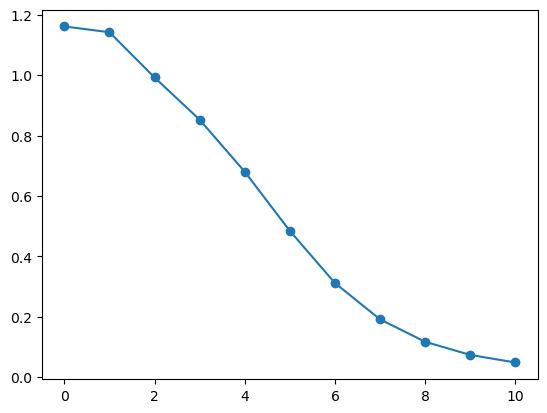

In [ ]:
m, n, k = 100, 40, 5
rand_seed = 10
np.random.seed(rand_seed)

def check_lorma_learn():
    from numpy.random import binomial, randn, uniform
    mockA, mockB = uniform(1, 2, (m, k)), uniform(-2, -1, (k, n))
    M = mockA @ mockB + 0.01 * np.random.randn(m, n)
    O = binomial(1, 0.5, size=M.shape)
    num_epochs = 100
    etas = 2.0 * np.ones(num_epochs)
    params = k, num_epochs, etas
    A, B, losses = lorma_learn(M, O, params)
    plt.plot(losses, '-o')
    return M, A, B

M, A, B = check_lorma_learn()

Visualizing the data matrix and it low-rank approximation

For reference let us also visualize a random matrix from the same distribution used for initialization.

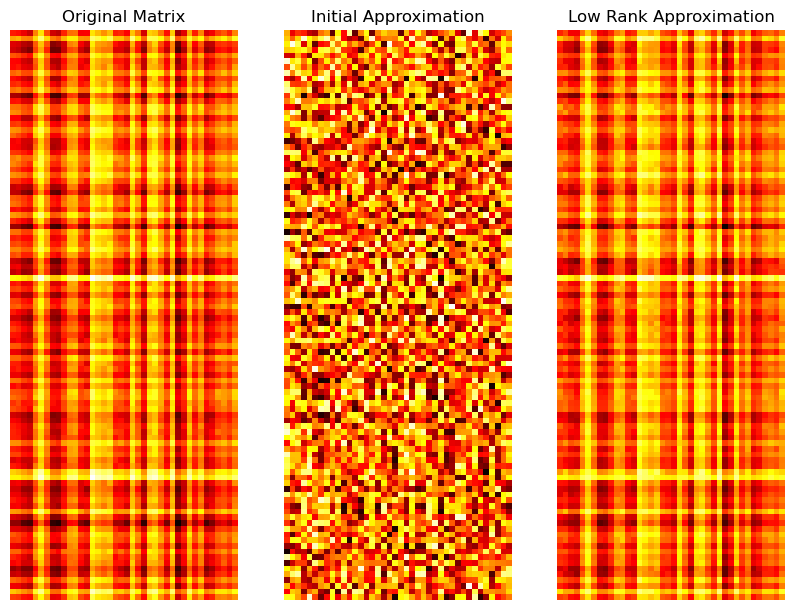

In [ ]:
def show_mat(X, str, ind):
    plt.subplot(1,3,ind)
    plt.imshow(X, cmap='hot')
    plt.axis('off')
    plt.title(str)

Ar, Br = lorma_init(m, n, k)
fig = plt.figure(figsize=(10,60))
show_mat(M, 'Original Matrix', 1)
show_mat(lorma(Ar, Br), 'Initial Approximation', 2)
show_mat(lorma(A, B), 'Low Rank Approximation', 3)

**Part 2: Movie Recommendation**
   
We will be using a smaller dataset called [MovieLens](https://grouplens.org/datasets/movielens/) and will be using the [pandas](https://pandas.pydata.org/) library (specifically [pandas.DataFrame](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.html)) to work with the dataset.


Download the MovieLens dataset

Credits: [MovieLens GitHub](https://github.com/khanhnamle1994/movielens/blob/master/ratings.csv)

In [ ]:
import pandas as pd

# Load the MovieLens dataset into a pandas dataframe (hint: use pd.read_csv) and display the top 5 rows of the dataset
ratings_path = 'ratings.csv'
ratings_df = pd.read_csv(ratings_path)# loads the dataset as a Pandas dataframe
ratings_df.head(5)# displays first 5 rows of dataframe


,userId,movieId,rating,timestamp
0,0,0,4.0,964982703
1,0,2,4.0,964981247
2,0,5,4.0,964982224
3,0,46,5.0,964983815
4,0,49,5.0,964982931


Convert DataFrame to matrix
 Convert the dataframe into a matrix where the rows (i.e. index) are users, the columns are movies, and the values are ratings.


In [ ]:
ratings_matrix_df = pd.DataFrame.pivot(ratings_df, index = 'userId', columns = 'movieId', values = 'rating')# converts dataframe to matrix form
ratings_matrix_df.head(5) # displays first 5 rows of matrix_df

movieId,0,1,2,3,4,5,6,7,8,9,...,193564,193566,193570,193572,193578,193580,193582,193584,193586,193608
userId,,,,,,,,,,,,,,,,,,,,,
0,4.0,NaN,4.0,NaN,NaN,4.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
missing_value = -1

ratings_matrix_processed = ratings_matrix_df.fillna(-1).to_numpy() ### your code here  # imputes NaN with -1
display(ratings_matrix_processed)# displays the full numpy as output (Note: intermediate values will be truncated with ... by default)

array([[ 4. , -1. ,  4. , ..., -1. , -1. , -1. ],
       [-1. , -1. , -1. , ..., -1. , -1. , -1. ],
       [-1. , -1. , -1. , ..., -1. , -1. , -1. ],
       ...,
       [ 2.5,  2. ,  2. , ..., -1. , -1. , -1. ],
       [ 3. , -1. , -1. , ..., -1. , -1. , -1. ],
       [ 5. , -1. , -1. , ..., -1. , -1. , -1. ]], shape=(610, 9724))

In [ ]:
# check data processing step
def check_data_processing(M):
  assert(np.sum(M == -1) == 5830804)
  assert(M.shape[0] == 610)
  assert(M.shape[1] == 9724)
  assert(M.dtype == 'float64')
  assert(M[0][0] == 4)
  assert(M[0][1] == -1)
  print("Matrix passes basic data processing checks.")

check_data_processing(ratings_matrix_processed)

Matrix passes basic data processing checks.


In the next cell, we provide the last data processing step.

We create an observed matrix called `rankings_observed` that stores a 1 where we have user ratings and a 0 otherwise.


In [ ]:
# Create the observed matrix with 1s where we have user ratings for a given movie and 0s otherwise
rankings_observed = np.where(ratings_matrix_processed == -1, 0, 1)

<hr style="border:3px solid blue"> </hr>


## Act 8: Run LORMA on the MovieLens dataset (10 pts)

Implement the following in the next code block:
1. Save a normalized version of the MovieLens data using `get_normalized_matrix`.
2. Define the parameters for LORMA (use rank = 40, epochs = 2000, eta = 10.0 for all epochs)
3. Run LORMA using the `lorma_learn` function
4. Plot losses to make sure they are decreasing.

**Hint:** Look at the function definition for `check_lorma_learn` for sample code on how to do steps 2-3.

**Note:** Running LORMA for 2000 epochs on the MovieLens dataset will take ~10 minutes in Colab.

Epoch 0 : 1.0242
Epoch 10 : 1.015
Epoch 20 : 1.0066
Epoch 30 : 0.9988
Epoch 40 : 0.9913
Epoch 50 : 0.984
Epoch 60 : 0.9768
Epoch 70 : 0.9695
Epoch 80 : 0.9621
Epoch 90 : 0.9543
Epoch 100 : 0.9461
Epoch 110 : 0.9373
Epoch 120 : 0.9279
Epoch 130 : 0.9177
Epoch 140 : 0.9064
Epoch 150 : 0.8942
Epoch 160 : 0.8808
Epoch 170 : 0.8662
Epoch 180 : 0.8505
Epoch 190 : 0.8337
Epoch 200 : 0.816
Epoch 210 : 0.7977
Epoch 220 : 0.7788
Epoch 230 : 0.7598
Epoch 240 : 0.7407
Epoch 250 : 0.7217
Epoch 260 : 0.7031
Epoch 270 : 0.6848
Epoch 280 : 0.6669
Epoch 290 : 0.6496
Epoch 300 : 0.6328
Epoch 310 : 0.6165
Epoch 320 : 0.6008
Epoch 330 : 0.5857
Epoch 340 : 0.5711
Epoch 350 : 0.5571
Epoch 360 : 0.5436
Epoch 370 : 0.5306
Epoch 380 : 0.5182
Epoch 390 : 0.5061
Epoch 400 : 0.4946
Epoch 410 : 0.4834
Epoch 420 : 0.4726
Epoch 430 : 0.4622
Epoch 440 : 0.4521
Epoch 450 : 0.4424
Epoch 460 : 0.433
Epoch 470 : 0.4239
Epoch 480 : 0.4151
Epoch 490 : 0.4065
Epoch 500 : 0.3982
Epoch 510 : 0.3902
Epoch 520 : 0.3824
Epoch 53

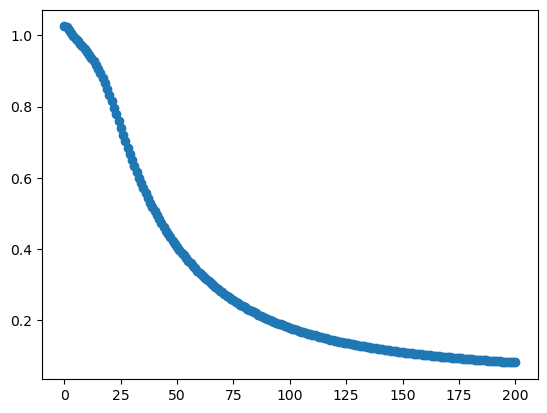

In [ ]:
"""
Act 8: Run LORMA on the MovieLens dataset.
"""
rand_seed = 10
np.random.seed(rand_seed)

# 1. Normalize the copied matrix
rankings_matrix_normalized = get_normalized_matrix(ratings_matrix_processed, rankings_observed)###

# 2. Define the parameters for LORMA
###
k = 40
num_epochs = 2000
etas = np.zeros(num_epochs)
etas += 10
params = k, num_epochs, etas

# 3. Run LORMA using the lorma_learn function
A, B, losses = lorma_learn(rankings_matrix_normalized,rankings_observed,params)

# 4. Plot the losses to make sure they are decreasing (given)
_ = plt.plot(losses, '-o')


Predicting Movie Preferences

In this final section, we'll analyze the movie preferences and predicted ratings for 3 users in our dataset (user 1, 13, and 111).


Loading movie information dataset

Credits: [MovieLens GitHub](https://github.com/khanhnamle1994/movielens/blob/master/movies.csv)

In [ ]:
# Load the movies
# The data consists of rows which are movie IDs
movie_info_path = 'movies.csv'
movie_info_df = pd.read_csv(movie_info_path)# loads the dataset as a Pandas dataframe
movie_info_df[:5]# displays first 5 rows of dataframe

,movieId,title,genres
0,0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,1,Jumanji (1995),Adventure|Children|Fantasy
2,2,Grumpier Old Men (1995),Comedy|Romance
3,3,Waiting to Exhale (1995),Comedy|Drama|Romance
4,4,Father of the Bride Part II (1995),Comedy


User Analysis

In the next cell, we'll analyze the user data for 3 specific users.

For each of the 3 users, we first compute the top `p` (i.e. top 10) movies that were most highly rated by that user.

Then, in the inner for loop (`for movie in top_p`), store the movie title, user rating, and movie genre in their respective variables. Finally, we'll print out that information for the top `p` movies for that user.


In [ ]:

# Pick three users to recommend movies to
users = [1, 13, 111]

# Let's see their tastes. Print the top-p movies they have rated highly
p = 10

# obtain the movie ids corresponding to the columns in `ratings_matrix_processed`
movie_ids = ratings_matrix_df.columns



for user in users:
    print(f"\nUser {user} liked the following:\n")

    # Sort the movies for this user in descending order based on the rating
    movie_order = np.argsort(-ratings_matrix_processed[user])
    top_p = movie_order[:p]

    # Print the top p movies
    for movie in top_p:
        # Obtain the movie title, user rating, and movie genre

        movie_id = movie_ids[movie]
        movie_info = movie_info_df.loc[movie_info_df['movieId']==movie_id]
        movie_title = movie_info['title'].squeeze()
        user_rating = ratings_matrix_processed[user,movie]
        movie_genre = movie_info['genres'].squeeze()
        print("\t{:<50} rated {:.1f}  genres {:<30}".format(
           movie_title, user_rating, movie_genre))





User 1 liked the following:

	The Jinx: The Life and Deaths of Robert Durst (2015) rated 5.0  genres Documentary                   
	Mad Max: Fury Road (2015)                          rated 5.0  genres Action|Adventure|Sci-Fi|Thriller
	Wolf of Wall Street, The (2013)                    rated 5.0  genres Comedy|Crime|Drama            
	Warrior (2011)                                     rated 5.0  genres Drama                         
	Inside Job (2010)                                  rated 5.0  genres Documentary                   
	Step Brothers (2008)                               rated 5.0  genres Comedy                        
	Inglourious Basterds (2009)                        rated 4.5  genres Action|Drama|War              
	Town, The (2010)                                   rated 4.5  genres Crime|Drama|Thriller          
	Good Will Hunting (1997)                           rated 4.5  genres Drama|Romance                 
	Dark Knight, The (2008)                            rated

Recommended Movies

In the next cell, we'll print out the top `p` (i.e. top 10) movies that are predicted for the 3 users we're studying.

For each of the 3 users, we first compute the predicted ratings for that user and save the top `p` predicted movies in descending order (we set the ratings for observed movies to -infinity so that we only save the top `p` movies that haven't been rated by the user).

Then, in the inner for loop (`for movie in top_p`), store the movie title and movie genre

In [ ]:


for user in users:
    print(f"\nRecommend the following movies to User {user}\n")

    # Predict the rating for these movies by performing a matrix multiplication between the user and movie vectors
    predicted_ratings = A[user,:] @ B

    # If the movie review was observed in the matrix, set it to (-infinity) so that we don't predict it
    # We want to predict only from a set of movies which the user has not seen
    predicted_ratings[rankings_observed[user] == 1] = -np.inf

    # Choose the top_p movies
    predicted_movie_order = np.argsort(-predicted_ratings)
    top_p = predicted_movie_order[:p]

    # Print the recommended movies
    for movie in top_p:
      movie_id = movie_ids[movie]
      movie_info = movie_info_df.loc[movie_info_df['movieId']== movie_id]
      movie_title = movie_info['title'].squeeze()
      movie_genre = movie_info['genres'].squeeze()
      user_rating = predicted_ratings[movie]
      print("\t{:<60} genres {:<30}".format(movie_title[:60], # cap length of movie title to 60 char
                                            movie_genre))


Recommend the following movies to User 1

	Life Is Beautiful (La Vita è bella) (1997)                   genres Comedy|Drama|Romance|War      
	Rumble in the Bronx (Hont faan kui) (1995)                   genres Action|Adventure|Comedy|Crime 
	Robin Hood: Men in Tights (1993)                             genres Comedy                        
	Million Dollar Baby (2004)                                   genres Drama                         
	Clueless (1995)                                              genres Comedy|Romance                
	Wallace & Gromit: The Best of Aardman Animation (1996)       genres Adventure|Animation|Comedy    
	Leaving Las Vegas (1995)                                     genres Drama|Romance                 
	Patton (1970)                                                genres Drama|War                     
	Beavis and Butt-Head Do America (1996)                       genres Adventure|Animation|Comedy|Crime
	Old Boy (2003)                                        